In [1]:
import os

In [2]:
import numpy as np

In [3]:
import glob

In [4]:
import PIL.Image as Image

In [5]:
from tqdm.notebook import tqdm

In [6]:
import torch

In [7]:
import torch.nn as nn

In [8]:
import torch.nn.functional as F

In [9]:
import torchvision.datasets as datasets

In [10]:
from torch.utils.data import DataLoader

In [11]:
import torchvision.transforms as transforms

In [12]:
import matplotlib.pyplot as plt

In [13]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [14]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/dtu/datasets1/02514/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

In [15]:
# The numbers of the normalization are from the ImageNET dataset
# Using ToTensor makes the images into a numbers between 0 and 1
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])
test_transform = transforms.Compose([transforms.Resize((size, size)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])

train_transforms_1 = transforms.Compose([transforms.Resize((size, size)),
                                         transforms.RandomRotation((90,90)),
                                         transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train_transforms_2 = transforms.Compose([transforms.Resize((size, size)),
                                         transforms.RandomRotation((180,180)),
                                         transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train_transforms_3 = transforms.Compose([transforms.Resize((size, size)),
                                         transforms.RandomRotation((270,270)),
                                         transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train_transforms_4 = transforms.Compose([transforms.Resize((size, size)),
                                         transforms.RandomHorizontalFlip(p=1.0),
                                         transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train_transforms_5 = transforms.Compose([transforms.Resize((size, size)),
                                         transforms.RandomCrop(size=(128, 128)),
                                         transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

batch_size = 128
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
trainset_1 = Hotdog_NotHotdog(train=True, transform=train_transforms_1)
trainset_2 = Hotdog_NotHotdog(train=True, transform=train_transforms_2)
trainset_3 = Hotdog_NotHotdog(train=True, transform=train_transforms_3)
trainset_4 = Hotdog_NotHotdog(train=True, transform=train_transforms_4)
trainset_5 = Hotdog_NotHotdog(train=True, transform=train_transforms_5)
concat_dataset = torch.utils.data.ConcatDataset([trainset])#, trainset_1, trainset_2, trainset_3, trainset_4, trainset_5])

train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=3)

testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

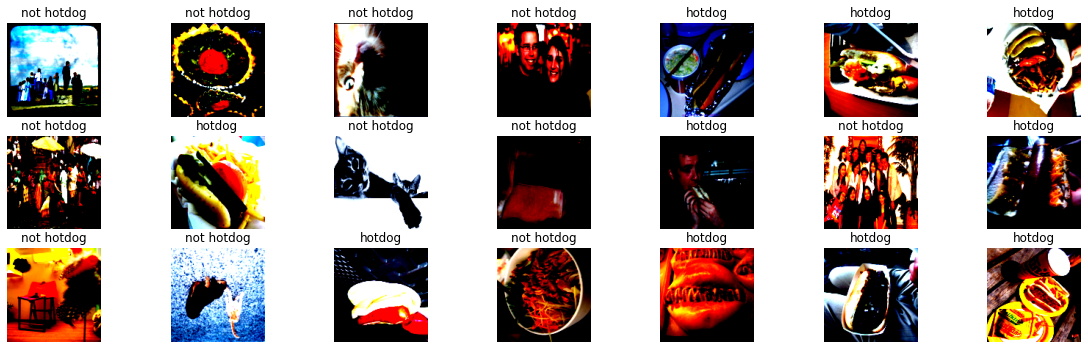

In [16]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')

In [16]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
                nn.Conv2d(3,
                          64,
                          kernel_size=3,
                          stride=1,
                          padding=1),
                nn.ReLU(),
                nn.Dropout(p=0.5),
                nn.Conv2d(64,
                          64,
                          kernel_size=3,
                          stride=1,
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                nn.BatchNorm2d(64),
            
                nn.Conv2d(64,
                          128,
                          kernel_size=3,
                          stride=1,
                          padding=1),
                nn.ReLU(),
                nn.Dropout(p=0.5),
                nn.Conv2d(128,
                          128,
                          kernel_size=3,
                          stride=1,
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                nn.BatchNorm2d(128),
            
                nn.Conv2d(128,
                          256,
                          kernel_size=3,
                          stride=1,
                          padding=1),
                nn.ReLU(),
                nn.Dropout(p=0.5),
                nn.Conv2d(256,
                          256,
                          kernel_size=3,
                          stride=1,
                          padding=1),
                nn.ReLU(),
                nn.Dropout(p=0.5),
                nn.Conv2d(256,
                          256,
                          kernel_size=3,
                          stride=1,
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                nn.BatchNorm2d(256),
        
                )
        
        self.fully_connected = nn.Sequential(
                nn.Linear(16*16*256, 4096),
                nn.ReLU(),
                nn.Dropout(p=0.5),
                nn.Linear(4096, 4096),
                nn.ReLU(),
                nn.Dropout(p=0.5),
                nn.Linear(4096, 1000),
                nn.ReLU(),
                nn.Dropout(p=0.5),
                nn.Linear(1000, 1000),
                nn.ReLU(),
                nn.Linear(1000, 1)
        )
    
    def forward(self, x):
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        x = nn.Sigmoid()(x)
        return x

In [17]:
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [18]:
early_stopping = EarlyStopping(tolerance=2, min_delta=0.2)

In [23]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        #return F.nll_loss(torch.log(output), target)
        return F.binary_cross_entropy(output, target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):

            data, target = data.to(device), target.to(device)
                
            target = target.to(torch.float32)
            #print(len(target))
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            #with torch.no_grad():
            output = model(data)
            
            #Compute the loss
            loss = loss_fun(output, target.reshape(-1,1))
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = torch.flatten(torch.where(output > 0.5, 1.0, 0.0))
            train_correct += (target==predicted).sum().cpu().item()
            #print(len(output))
            #print(len(predicted))
            #print("------------------")
            
        #print(train_correct)
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            target = target.to(torch.float32)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target.reshape(-1,1)).cpu().item())
            predicted = torch.flatten(torch.where(output > 0.5, 1.0, 0.0))
            test_correct += (target==predicted).sum().cpu().item()
            
        out_dict['train_acc'].append(train_correct/len(concat_dataset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    
        print("I should check for early stopping")
        # early stopping
        early_stopping(np.mean(train_loss), np.mean(test_loss))
        if early_stopping.early_stop:
          print("We are at epoch:", epoch)
          break
    return out_dict

In [24]:
model = Network()
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.90)
optimizer_adam = torch.optim.Adam(model.parameters())

In [25]:
out_dict = train(model, optimizer_adam,num_epochs=10)

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/16 [00:00<?, ?it/s]

tensor([[[[ 1.4783,  1.4440,  1.4612,  ...,  1.0502,  1.0159,  0.9474],
          [ 1.4612,  1.4440,  1.4440,  ...,  1.1529,  1.1187,  1.0844],
          [ 1.4269,  1.4269,  1.4269,  ...,  1.1872,  1.1700,  1.1529],
          ...,
          [-1.8610, -1.8439, -1.8953,  ..., -2.1008, -2.1008, -2.1008],
          [-1.7412, -1.7583, -1.7754,  ..., -2.1008, -2.1008, -2.1179],
          [-1.7754, -1.7925, -1.7583,  ..., -2.1179, -2.1008, -2.1179]],

         [[ 0.8529,  0.8354,  0.8529,  ...,  0.6779,  0.6254,  0.5728],
          [ 0.8354,  0.8354,  0.8354,  ...,  0.7479,  0.7129,  0.6779],
          [ 0.8179,  0.8179,  0.8179,  ...,  0.7654,  0.7479,  0.7304],
          ...,
          [-1.7206, -1.7031, -1.7731,  ..., -2.0182, -2.0007, -2.0182],
          [-1.5980, -1.6155, -1.6155,  ..., -2.0357, -2.0357, -2.0357],
          [-1.6331, -1.6506, -1.5980,  ..., -2.0357, -2.0357, -2.0357]],

         [[ 0.5659,  0.5834,  0.5659,  ...,  0.5834,  0.5834,  0.5659],
          [ 0.5485,  0.5485,  

In [42]:
layers=[x.data for x in model.parameters()]
layers[0].cpu().detach().numpy().shape

(64, 3, 3, 3)

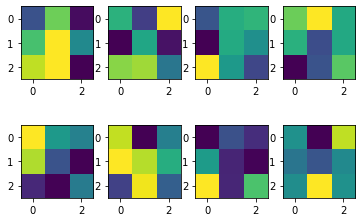

In [26]:
fig, ax = plt.subplots(2,4)
ax[0,0].imshow(layers[0].cpu().detach().numpy()[0][0],interpolation='none')
ax[0,1].imshow(layers[0].cpu().detach().numpy()[1][0],interpolation='none')
ax[0,2].imshow(layers[0].cpu().detach().numpy()[2][0],interpolation='none')
ax[0,3].imshow(layers[0].cpu().detach().numpy()[3][0],interpolation='none')
ax[1,0].imshow(layers[0].cpu().detach().numpy()[4][0],interpolation='none')
ax[1,1].imshow(layers[0].cpu().detach().numpy()[5][0],interpolation='none')
ax[1,2].imshow(layers[0].cpu().detach().numpy()[6][0],interpolation='none')
ax[1,3].imshow(layers[0].cpu().detach().numpy()[7][0],interpolation='none')

Text(0, 0.5, 'Accuracy')

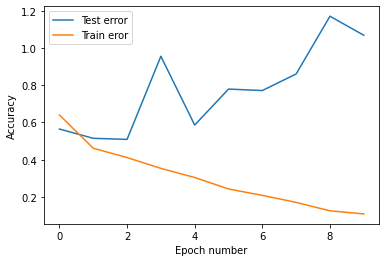

In [21]:
plt.plot(np.arange(10),np.array(out_dict["test_loss"]),'-')
plt.plot(np.arange(10),np.array(out_dict["train_loss"]),'-')
plt.legend(('Test error','Train eror'))
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

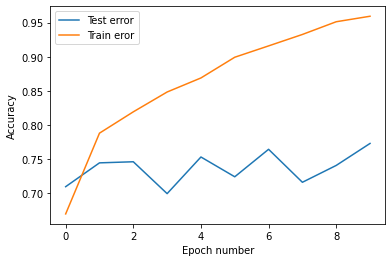

In [22]:
plt.plot(np.arange(10),np.array(out_dict["test_acc"]),'-')
plt.plot(np.arange(10),np.array(out_dict["train_acc"]),'-')
plt.legend(('Test error','Train eror'))
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')

In [24]:
test_correct = 0
targets = np.array([])
predictions = np.array([])
data_images = []

In [25]:
def loss_fun(output, target):
    #return F.nll_loss(torch.log(output), target)
    return F.binary_cross_entropy(output, target)
test_loss = []
test_correct = 0
model.eval()
i = 0
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    target = target.to(torch.float32)
    with torch.no_grad():
        output = model(data)
    test_loss.append(loss_fun(output, target.reshape(-1,1)).cpu().item())
    predicted = torch.flatten(torch.where(output > 0.5, 1.0, 0.0))
    test_correct += (target==predicted).sum().cpu().item()
    i += 1
    targets = np.concatenate((targets,target.cpu().detach().numpy()))
    predictions = np.concatenate((predictions,predicted.cpu().detach().numpy()))
    #if i != 29:
    data_images.append(data[:].cpu().detach().numpy())

In [ ]:
images, labels = next(iter(test_loader))

In [58]:
plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))

1920

Text(0.5, 0, 'targets')

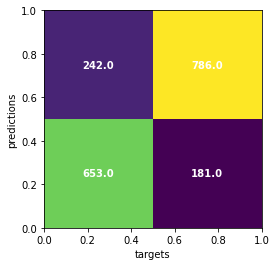

In [26]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
hist, xbins, ybins, im = ax.hist2d(targets, predictions,bins=[2,2])
for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        ax.text(xbins[j]+0.25,ybins[i]+0.25, hist.T[i,j], 
                color="w", ha="center", va="center", fontweight="bold")
ax.set_ylabel('predictions')
ax.set_xlabel('targets')

In [19]:
import torch.optim as optim

In [20]:
from torch.optim import lr_scheduler

In [21]:
import torch.backends.cudnn as cudnn

In [22]:
from torchvision import datasets, models, transforms

In [171]:
model_ft = None

In [172]:
model_ft = models.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /zhome/82/e/180411/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [173]:
num_ftrs = model_ft.fc.in_features

In [174]:
model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 1),nn.Sigmoid())

In [175]:
model_ft = model_ft.to(device)

In [176]:
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.90)
optimizer_adam = torch.optim.Adam(model_ft.parameters())

In [179]:
early_stopping = EarlyStopping(tolerance=2, min_delta=0.1)

In [180]:
out_dict_resnet = {}

In [181]:
out_dict_resnet = train(model_ft, optimizer,num_epochs=10)

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.050	 test: 0.199	 Accuracy train: 98.6%	 test: 93.3%
I should check for early stopping


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.007	 test: 0.196	 Accuracy train: 100.0%	 test: 93.6%
I should check for early stopping


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.002	 test: 0.198	 Accuracy train: 100.0%	 test: 93.8%
I should check for early stopping


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.001	 test: 0.199	 Accuracy train: 100.0%	 test: 94.1%
I should check for early stopping


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.001	 test: 0.202	 Accuracy train: 100.0%	 test: 94.0%
I should check for early stopping


  0%|          | 0/16 [00:00<?, ?it/s]

Loss train: 0.000	 test: 0.203	 Accuracy train: 100.0%	 test: 94.0%
I should check for early stopping
We are at epoch: 5


In [35]:
model_vgg19 = None

In [36]:
model_vgg19 = models.vgg19(pretrained=True)

In [37]:
for param in model_vgg19.parameters():
    param.requires_grad = False
    # Replace the last fully-connected layer
    # Parameters of newly constructed modules have requires_grad=True by default

In [38]:
model_vgg19.classifier[6].out_features

1000

In [39]:
model_vgg19.fc = nn.Sequential(nn.Linear(1000, 1),nn.Sigmoid())

In [40]:
optimizer = torch.optim.SGD(model_vgg19.parameters(), lr=0.01, momentum=0.90)
optimizer_adam = torch.optim.Adam(model_vgg19.parameters())

In [41]:
early_stopping = EarlyStopping(tolerance=2, min_delta=0.1)

In [42]:
out_dict_resnet = {}

In [44]:
model_vgg19 = model_vgg19.to(device)

RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 31.75 GiB total capacity; 1.16 GiB already allocated; 319.44 MiB free; 1.19 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [34]:
out_dict_vgg19 = train(model_vgg19, optimizer,num_epochs=10)

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/16 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 31.75 GiB total capacity; 1.08 GiB already allocated; 401.44 MiB free; 1.11 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF